# Machine Learning Predictions for the 2019-2020 All-NBA team

I set out wanting to predict this season's MVP but that was too difficult for a number of reasons. I looked through the Sci-Kit documentation and was particularly drawn to the Classification section. At first I thought maybe the MVP is really just a classification problem, but after further thought I decided that wasn't the case. When a Center is selected to be the MVP, he is expected to excel in different areas then a point guard. So the classification for a Point Guard MVP should theoretically be different from a Center MVP. From there, I decided that it should be possible to use a Classification model to predict the MVP for each position, which is EXACTLY what the All-NBA team is. The All-NBA team has high stakes -- making the team often earns a player millions of dollars in contract incentives.

**You must use pip to install basketball_reference_web_scraper otherwise none of this will work. Install it using the following command: pip install basketball_reference_web_scraper** 

Note: I originally had an issue installing it which was solved by running the command like this:
pip install basketball_reference_web_scraper --ignore-installed

**Please run each cell in order!! The first cell takes a while to run since it is retrieving a lot of data. Just wait for it to finish**


First, to get the data:

I added in some calculated stats like field goal percentage and points.

Also, if a player was moved midseason, I combined their totals from each team.

In [7]:
from basketball_reference_web_scraper import client
import collections
import copy
import pandas as pd

statsToAdd = ['games_played', 'games_started', 'minutes_played', 'made_field_goals', 'attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'offensive_rebounds', 'defensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

statDict = {}
for year in range(2001, 2021):
    yearPlayers = client.players_season_totals(season_end_year=year)
    playerIdList = [player['slug'] for player in yearPlayers]
    tradedPlayersIdList = [playerId for playerId, count in collections.Counter(playerIdList).items() if count > 1]
    for tradedPlayerId in tradedPlayersIdList:
        playerStatsList = []
        toDelete = []
        totalPlayerStats = {'slug': '', 'name': '', 'positions': [], 'age': 0, 'team': 0, 'games_played': 0, 'games_started': 0, 'minutes_played': 0, 'made_field_goals': 0, 'attempted_field_goals': 0, 'made_three_point_field_goals': 0, 'attempted_three_point_field_goals': 0, 'made_free_throws': 0, 'attempted_free_throws': 0, 'offensive_rebounds': 0, 'defensive_rebounds': 0, 'assists': 0, 'steals': 0, 'blocks': 0, 'turnovers': 0, 'personal_fouls': 0}
        for idx, player in enumerate(yearPlayers):
            if tradedPlayerId == player['slug']:
                playerStatsList.append(player)
                toDelete.append(idx)
        for i in toDelete:
            yearPlayers.pop(toDelete[0])
        for playerTeamStats in playerStatsList:
            if totalPlayerStats['slug'] == '':
                totalPlayerStats['slug'] = playerTeamStats['slug']
            if totalPlayerStats['name'] == '':
                totalPlayerStats['name'] = playerTeamStats['name']
            if totalPlayerStats['positions'] == []:
                totalPlayerStats['positions'] = playerTeamStats['positions']
            if totalPlayerStats['age'] == 0:
                totalPlayerStats['age'] = playerTeamStats['age']
            if totalPlayerStats['team'] == 0:
                totalPlayerStats['team'] = playerTeamStats['team']
            for statName in statsToAdd:
                totalPlayerStats[statName] = totalPlayerStats[statName] + playerTeamStats[statName]
        yearPlayers.append(totalPlayerStats)
        for player in yearPlayers:
            if(player['attempted_field_goals'] != 0):
                player['effective_field_goal_percentage'] = (player['made_field_goals'] + (.5 * player['made_three_point_field_goals'])) / player['attempted_field_goals']
            else:
                player['effective_field_goal_percentage'] = 0
            player['total_points'] = (player['made_three_point_field_goals'] * 3) + ((player['made_field_goals'] - player['made_three_point_field_goals']) * 2) + (player['made_free_throws'])
            if(player['attempted_free_throws'] != 0):
                player['free_throw_percentage'] = player['made_free_throws'] / player['attempted_free_throws']
            else:
                player['free_throw_percentage'] = 0
    statDict[year] = yearPlayers



In [8]:
for year in range(2001, 2021):
    for game in client.season_schedule(season_end_year=year):
        for player in statDict[year]:
            if "team_games_played" in player and player["team_games_played"] >= 82:
                break
            if player["team"] == game["home_team"] or player["team"] == game["away_team"]:
                if "team_games_played" in player:
                    player["team_games_played"] += 1
                else:
                    player["team_games_played"] = 1
            if game["home_team_score"] > game["away_team_score"]:
                if player["team"] == game["home_team"]:
                    if "wins" in player:
                        player["wins"] += 1
                    else:
                        player["wins"] = 1
            else:
                if player["team"] == game["away_team"]:
                    if "wins" in player:
                        player["wins"] += 1
                    else:
                        player["wins"] = 1

In [9]:
currentStatDict = copy.deepcopy(statDict[2020])
statDict.pop(2020)
print(currentStatDict)

[{'slug': 'adamsst01', 'name': 'Steven Adams', 'positions': [<Position.CENTER: 'CENTER'>], 'age': 26, 'team': <Team.OKLAHOMA_CITY_THUNDER: 'OKLAHOMA CITY THUNDER'>, 'games_played': 58, 'games_started': 58, 'minutes_played': 1564, 'made_field_goals': 262, 'attempted_field_goals': 443, 'made_three_point_field_goals': 1, 'attempted_three_point_field_goals': 3, 'made_free_throws': 108, 'attempted_free_throws': 183, 'offensive_rebounds': 196, 'defensive_rebounds': 347, 'assists': 141, 'steals': 50, 'blocks': 65, 'turnovers': 86, 'personal_fouls': 111, 'points': 633, 'effective_field_goal_percentage': 0.59255079006772, 'total_points': 633, 'free_throw_percentage': 0.5901639344262295, 'team_games_played': 64, 'wins': 40}, {'slug': 'adebaba01', 'name': 'Bam Adebayo', 'positions': [<Position.POWER_FORWARD: 'POWER FORWARD'>], 'age': 22, 'team': <Team.MIAMI_HEAT: 'MIAMI HEAT'>, 'games_played': 65, 'games_started': 65, 'minutes_played': 2235, 'made_field_goals': 408, 'attempted_field_goals': 719, 

Using beautiful soup to get a nice clean list of the all-nba players since 2000.

In [10]:
from bs4 import BeautifulSoup
import urllib.request
import collections
import re
import bs4
import lxml

url = 'https://www.basketball-reference.com/awards/all_league.html'

soup = BeautifulSoup()

textList = []
allNbaTeamDict = {}
with urllib.request.urlopen(url) as ef:
    soup = BeautifulSoup(ef)
    textList = soup.find('table').get_text().splitlines()[15:]

    for line in textList:
        year = line[:7]
        formattedYear = year[:2] + year[5:]
        if formattedYear == '1900':
            formattedYear = '2001'
        if year == '1999-00':
            break
        if formattedYear not in allNbaTeamDict:
            allNbaTeamDict[formattedYear] = []
        wordList = line[13:].split()
        if len(wordList) == 0:
            continue
        playerTuple = (wordList[2][0],"%s %s" % (wordList[0], wordList[1]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[4][0],"%s %s" % (wordList[2][1:], wordList[3]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[6][0],"%s %s" % (wordList[4][1:], wordList[5]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[8][0],"%s %s" % (wordList[6][1:], wordList[7]))
        allNbaTeamDict[formattedYear].append(playerTuple)
        playerTuple = (wordList[10][0],"%s %s" % (wordList[8][1:], wordList[9]))
        allNbaTeamDict[formattedYear].append(playerTuple)
    allNbaTeamDict.pop('')
print(allNbaTeamDict)

{'2019': [('C', 'Nikola Jokić'), ('F', 'Giannis Antetokounmpo'), ('F', 'Paul George'), ('G', 'James Harden'), ('G', 'Stephen Curry'), ('C', 'Joel Embiid'), ('F', 'Kevin Durant'), ('F', 'Kawhi Leonard'), ('G', 'Damian Lillard'), ('G', 'Kyrie Irving'), ('C', 'Rudy Gobert'), ('F', 'LeBron James'), ('F', 'Blake Griffin'), ('G', 'Kemba Walker'), ('G', 'Russell Westbrook')], '2018': [('C', 'Anthony Davis'), ('F', 'LeBron James'), ('F', 'Kevin Durant'), ('G', 'Damian Lillard'), ('G', 'James Harden'), ('C', 'Joel Embiid'), ('F', 'Giannis Antetokounmpo'), ('F', 'LaMarcus Aldridge'), ('G', 'Russell Westbrook'), ('G', 'DeMar DeRozan'), ('C', 'Karl-Anthony Towns'), ('F', 'Jimmy Butler'), ('F', 'Paul George'), ('G', 'Stephen Curry'), ('G', 'Victor Oladipo')], '2017': [('C', 'Anthony Davis'), ('F', 'LeBron James'), ('F', 'Kawhi Leonard'), ('G', 'James Harden'), ('G', 'Russell Westbrook'), ('C', 'Rudy Gobert'), ('F', 'Giannis Antetokounmpo'), ('F', 'Kevin Durant'), ('G', 'Stephen Curry'), ('G', 'Isai

Adding the all_nba_type back into our stat dictionary:

In [11]:
relevantCenterData = []
relevantForwardData = []
relevantGuardData = []
for year in allNbaTeamDict:
    for position, playerName in allNbaTeamDict[str(year)]:
        if position == 'C':
            for player in statDict[int(year)]:
                if player['name'] == playerName:
                    relevantCenterData.append(player)
        elif position == 'F':
            for player in statDict[int(year)]:
                if player['name'] == playerName:
                    relevantForwardData.append(player)
        elif position == 'G':
            for player in statDict[int(year)]:
                if player['name'] == playerName:
                    relevantGuardData.append(player)
                

In [12]:
# 1 = All-NBA center, 2 = All-NBA forward, 3 = All-NBA guard, 0 = regular player
for playerSeason in relevantCenterData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 1
for playerSeason in relevantForwardData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 2
for playerSeason in relevantGuardData:
    for year in statDict:
        for player in statDict[int(year)]:
            if player == playerSeason:
                player['all_nba_type'] = 3
flattenedStats = []
for year in statDict:
        for player in statDict[int(year)]:
            if 'all_nba_type' not in player:
                player['all_nba_type'] = 0
            flattenedStats.append(player)

historicalDf = pd.DataFrame.from_dict(flattenedStats)
currentDf = pd.DataFrame.from_dict(currentStatDict)
historicalDf.describe()


,age,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,...,blocks,turnovers,personal_fouls,points,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type
count,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,...,8874.000000,8874.000000,8874.000000,7806.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000,8874.000000
mean,26.638833,53.266734,25.878972,1251.586996,192.703403,425.635903,36.345842,102.004620,94.231801,124.472955,...,25.366464,71.631846,108.820261,532.802075,0.473686,515.984449,0.700573,80.334009,39.920216,0.050034
std,4.322034,25.006668,29.142600,903.247901,173.202731,372.633601,48.948826,129.303639,106.098018,134.392012,...,33.870831,62.680901,73.057498,483.166013,0.099670,473.007812,0.194316,2.646965,12.392695,0.343310
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000,7.000000,0.000000
25%,23.000000,33.000000,1.000000,412.000000,47.250000,112.000000,0.000000,2.000000,18.000000,27.000000,...,4.000000,20.000000,44.000000,130.000000,0.442446,123.000000,0.645161,81.000000,31.000000,0.000000
50%,26.000000,61.000000,11.000000,1183.500000,151.000000,339.500000,12.000000,39.500000,59.000000,81.000000,...,13.000000,57.000000,107.000000,421.000000,0.483312,399.000000,0.750000,81.000000,41.000000,0.000000
75%,30.000000,75.000000,52.000000,1984.000000,294.000000,647.000000,60.000000,171.000000,133.000000,179.000000,...,32.000000,106.000000,164.000000,813.000000,0.519927,783.000000,0.815360,81.000000,49.000000,0.000000
max,44.000000,85.000000,83.000000,3485.000000,978.000000,2173.000000,402.000000,1028.000000,756.000000,972.000000,...,307.000000,464.000000,344.000000,2832.000000,1.500000,2832.000000,1.000000,82.000000,72.000000,3.000000


In [13]:
relevant_stats_for_scaling = ['wins','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']
for stat_name in relevant_stats_for_scaling:
    currentDf[stat_name] = currentDf[stat_name] * (82 / currentDf.team_games_played)
currentDf.describe()
currentDf.head()

,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,steals,blocks,turnovers,personal_fouls,points,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins
0,adamsst01,Steven Adams,[Position.CENTER],26,Team.OKLAHOMA_CITY_THUNDER,74.312500,74.312500,2003.875000,335.687500,567.593750,...,64.062500,83.281250,110.187500,111,633.0,0.759206,811.031250,0.756148,64,51.250000
1,adebaba01,Bam Adebayo,[Position.POWER_FORWARD],22,Team.MIAMI_HEAT,82.000000,82.000000,2819.538462,514.707692,907.046154,...,98.400000,107.230769,233.384615,164,1053.0,0.716743,1328.400000,0.870535,65,51.723077
2,aldrila01,LaMarcus Aldridge,[Position.CENTER],34,Team.SAN_ANTONIO_SPURS,68.984127,68.984127,2282.984127,508.920635,1032.158730,...,46.857143,113.238095,96.317460,128,1001.0,0.691827,1302.888889,1.076706,63,35.142857
3,alexani01,Nickeil Alexander-Walker,[Position.SHOOTING_GUARD],21,Team.NEW_ORLEANS_PELICANS,52.531250,0.000000,641.906250,98.656250,290.843750,...,14.093750,8.968750,51.250000,46,211.0,0.547494,270.343750,0.777902,64,35.875000
4,allengr01,Grayson Allen,[Position.SHOOTING_GUARD],24,Team.MEMPHIS_GRIZZLIES,37.846154,0.000000,628.246154,99.661538,222.030769,...,7.569231,1.261538,29.015385,36,221.0,0.684528,278.800000,1.081319,65,40.369231


Now I have all of the All-NBA players since year 1999-2000 season and their stats, along with whether they made an All-NBA team or not, and which team they made. Now to select relevant statistic:

In [14]:

relevantStatsHistoricalDf = historicalDf[['wins','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage', 'all_nba_type']]
relevantStatsHistoricalDf.head()



,wins,free_throw_percentage,turnovers,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,assists,blocks,steals,total_points,offensive_rebounds,defensive_rebounds,effective_field_goal_percentage,all_nba_type
0,23,0.758621,26,41,0,486,120,246,4,14,22,29,76,1,9,266,5,20,0.495935,0
1,40,0.583333,34,29,12,420,43,111,4,10,21,36,22,13,14,111,14,45,0.405405,0
2,22,0.834275,231,81,81,3241,604,1280,12,64,443,531,250,77,90,1663,175,560,0.476562,0
3,43,0.666667,25,26,0,227,18,56,4,16,12,18,36,0,16,52,0,25,0.357143,0
4,52,0.887755,204,82,82,3129,628,1309,202,467,348,392,374,20,124,1806,101,327,0.556914,0


In [15]:
display(relevantStatsHistoricalDf[relevantStatsHistoricalDf.isna().any(axis=1)])

,wins,free_throw_percentage,turnovers,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,assists,blocks,steals,total_points,offensive_rebounds,defensive_rebounds,effective_field_goal_percentage,all_nba_type


In [16]:
relevantStatsCurrentDf = currentDf[['wins','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']] 
relevantStatsCurrentDf.head()


,wins,free_throw_percentage,turnovers,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,assists,blocks,steals,total_points,offensive_rebounds,defensive_rebounds,effective_field_goal_percentage
0,51.250000,0.756148,110.187500,74.312500,74.312500,2003.875000,335.687500,567.593750,1.281250,3.843750,138.375000,234.468750,180.656250,83.281250,64.062500,811.031250,251.125000,444.593750,0.759206
1,51.723077,0.870535,233.384615,82.000000,82.000000,2819.538462,514.707692,907.046154,1.261538,16.400000,297.723077,431.446154,420.092308,107.230769,98.400000,1328.400000,208.153846,653.476923,0.716743
2,35.142857,1.076706,96.317460,68.984127,68.984127,2282.984127,508.920635,1032.158730,79.396825,204.349206,205.650794,248.603175,167.904762,113.238095,46.857143,1302.888889,134.063492,376.158730,0.691827
3,35.875000,0.777902,51.250000,52.531250,0.000000,641.906250,98.656250,290.843750,51.250000,149.906250,21.781250,35.875000,94.812500,8.968750,14.093750,270.343750,10.250000,92.250000,0.547494
4,40.369231,1.081319,29.015385,37.846154,0.000000,628.246154,99.661538,222.030769,41.630769,114.800000,37.846154,44.153846,54.246154,1.261538,7.569231,278.800000,6.307692,76.953846,0.684528


In [17]:
# help from here: http://ataspinar.com/2017/05/26/classification-with-scikit-learn/
# I used the code from this guide and applied it to my data

import numpy as np
def get_train_test(df, y_col, x_cols, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(df)) <= ratio
    df_train = df[mask]
    df_test = df[~mask]
       
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    X_train = df_train[x_cols].values
    X_test = df_test[x_cols].values
    return df_train, df_test, X_train, Y_train, X_test, Y_test

y_col = 'all_nba_type'
x_cols = list(relevantStatsHistoricalDf.columns.values)
x_cols.remove(y_col)

train_test_ratio = 0.7
df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(relevantStatsHistoricalDf, y_col, x_cols, train_test_ratio)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
}

rfPredictions = []

def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models



def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

dict_models = batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 8)
display_dict_models(dict_models)

/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.proc

trained Logistic Regression in 1.27 s
trained Nearest Neighbors in 0.04 s
trained Linear SVM in 0.08 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages

trained Gradient Boosting Classifier in 22.70 s
trained Decision Tree in 0.04 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Random Forest in 5.89 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Neural Net in 5.38 s
trained Naive Bayes in 0.02 s


/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/aratzan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


,classifier,train_score,test_score,train_time
3,Gradient Boosting Classifier,1.000000,0.984917,22.699614
5,Random Forest,1.000000,0.983786,5.885615
0,Logistic Regression,0.979589,0.981146,1.270640
1,Nearest Neighbors,0.983767,0.981146,0.042110
6,Neural Net,0.980392,0.980769,5.378346
4,Decision Tree,1.000000,0.978130,0.037540
2,Linear SVM,0.976696,0.976998,0.080253
7,Naive Bayes,0.875924,0.876697,0.016767


So we can see that the Random Forest classifier was very accurate! The question is, did it correctly predict the all_nba_team values? There are far fewer all nba players compared to total players so this accuracy could be meaningless, meaning it just usually predicted 0. Now to try to use this model on the current data and see who it predicts to be on the all-nba team.

In [19]:
rfPredictions = dict_models['Random Forest']['model'].predict(relevantStatsCurrentDf)
rfPredictions = rfPredictions.tolist()
print(len(rfPredictions))
currentDf['all_nba_type'] = rfPredictions
resultsDf = currentDf.loc[currentDf['all_nba_type'] > 0]
display(resultsDf)

514


,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,blocks,turnovers,personal_fouls,points,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type
11,antetgi01,Giannis Antetokounmpo,[Position.POWER_FORWARD],25,Team.MILWAUKEE_BUCKS,71.907692,71.907692,2224.092308,785.938462,1436.892308,...,73.169231,263.661538,173,1690.0,0.735990,2132.000000,0.798974,65,66.861538,2
99,davisan02,Anthony Davis,[Position.POWER_FORWARD],26,Team.LOS_ANGELES_LAKERS,71.587302,71.587302,2458.698413,661.206349,1293.777778,...,174.412698,175.714286,138,1467.0,0.707754,1909.428571,1.099371,63,63.777778,2
108,doncilu01,Luka Dončić,[Position.POINT_GUARD],20,Team.DALLAS_MAVERICKS,66.089552,66.089552,2201.761194,626.626866,1359.731343,...,12.238806,277.820896,134,1549.0,0.649946,1895.791045,0.919780,67,48.955224,2
145,goberru01,Rudy Gobert,[Position.CENTER],27,Team.UTAH_JAZZ,79.437500,79.437500,2744.437500,452.281250,648.312500,...,158.875000,153.750000,196,934.0,0.893836,1196.687500,0.795981,64,52.531250,1
164,hardeja01,James Harden,[Position.SHOOTING_GUARD],30,Team.HOUSTON_ROCKETS,78.156250,78.156250,2871.281250,772.593750,1775.812500,...,67.906250,349.781250,206,2096.0,0.682686,2685.500000,1.103051,64,51.250000,2
211,jamesle01,LeBron James,[Position.POINT_GUARD],35,Team.LOS_ANGELES_LAKERS,78.095238,78.095238,2725.523810,762.730159,1530.666667,...,39.047619,311.079365,106,1544.0,0.722182,2009.650794,0.906937,63,63.777778,2
251,leonaka01,Kawhi Leonard,[Position.SMALL_FORWARD],28,Team.LOS_ANGELES_CLIPPERS,65.343750,65.343750,2105.093750,609.875000,1301.750000,...,39.718750,179.375000,98,1370.0,0.667738,1755.312500,1.138482,64,56.375000,2
254,lillada01,Damian Lillard,[Position.POINT_GUARD],29,Team.PORTLAND_TRAIL_BLAZERS,72.060606,72.060606,2658.787879,659.727273,1443.696970,...,26.090909,208.727273,98,1677.0,0.688572,2083.545455,1.103432,66,36.030303,3
439,westbru01,Russell Westbrook,[Position.POINT_GUARD],31,Team.HOUSTON_ROCKETS,67.906250,67.906250,2440.781250,727.750000,1536.218750,...,21.781250,302.375000,187,1456.0,0.634213,1865.500000,0.996116,64,51.250000,2
456,youngtr01,Trae Young,[Position.POINT_GUARD],21,Team.ATLANTA_HAWKS,73.432836,73.432836,2594.626866,668.238806,1528.626866,...,9.791045,353.701493,104,1778.0,0.635458,2176.059701,1.053107,67,24.477612,3


In [23]:
activation_scores = dict_models['Random Forest']['model'].predict_proba(relevantStatsCurrentDf)
activation_scores = activation_scores.tolist()
currentDf['0_score'] = [score[0] for score in activation_scores]
currentDf['1_score'] = [score[1] for score in activation_scores]
currentDf['2_score'] = [score[2] for score in activation_scores]
currentDf['3_score'] = [score[3] for score in activation_scores]
centersDf = currentDf.sort_values('1_score', ascending=False)
display(centersDf.head(5))
forwardsDf = currentDf.sort_values('2_score', ascending=False)
display(forwardsDf.head(8))
guardsDf = currentDf.sort_values('3_score', ascending=False)
display(guardsDf.head(7))



,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type,0_score,1_score,2_score,3_score
145,goberru01,Rudy Gobert,[Position.CENTER],27,Team.UTAH_JAZZ,79.437500,79.437500,2744.437500,452.281250,648.312500,...,0.893836,1196.687500,0.795981,64,52.531250,1,0.457,0.472,0.069,0.002
1,adebaba01,Bam Adebayo,[Position.POWER_FORWARD],22,Team.MIAMI_HEAT,82.000000,82.000000,2819.538462,514.707692,907.046154,...,0.716743,1328.400000,0.870535,65,51.723077,0,0.527,0.298,0.149,0.026
442,whiteha01,Hassan Whiteside,[Position.CENTER],30,Team.PORTLAND_TRAIL_BLAZERS,75.787879,75.787879,2374.272727,519.333333,839.878788,...,0.771920,1233.727273,0.844848,66,36.030303,0,0.722,0.237,0.040,0.001
5,allenja01,Jarrett Allen,[Position.CENTER],21,Team.BROOKLYN_NETS,82.000000,74.312500,2110.218750,342.093750,529.156250,...,0.828314,872.531250,0.794699,64,38.437500,0,0.784,0.212,0.004,0.000
99,davisan02,Anthony Davis,[Position.POWER_FORWARD],26,Team.LOS_ANGELES_LAKERS,71.587302,71.587302,2458.698413,661.206349,1293.777778,...,0.707754,1909.428571,1.099371,63,63.777778,2,0.187,0.202,0.576,0.035


,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type,0_score,1_score,2_score,3_score
251,leonaka01,Kawhi Leonard,[Position.SMALL_FORWARD],28,Team.LOS_ANGELES_CLIPPERS,65.343750,65.343750,2105.093750,609.875000,1301.750000,...,0.667738,1755.312500,1.138482,64,56.375000,2,0.205,0.022,0.643,0.130
11,antetgi01,Giannis Antetokounmpo,[Position.POWER_FORWARD],25,Team.MILWAUKEE_BUCKS,71.907692,71.907692,2224.092308,785.938462,1436.892308,...,0.735990,2132.000000,0.798974,65,66.861538,2,0.211,0.134,0.597,0.058
99,davisan02,Anthony Davis,[Position.POWER_FORWARD],26,Team.LOS_ANGELES_LAKERS,71.587302,71.587302,2458.698413,661.206349,1293.777778,...,0.707754,1909.428571,1.099371,63,63.777778,2,0.187,0.202,0.576,0.035
211,jamesle01,LeBron James,[Position.POINT_GUARD],35,Team.LOS_ANGELES_LAKERS,78.095238,78.095238,2725.523810,762.730159,1530.666667,...,0.722182,2009.650794,0.906937,63,63.777778,2,0.195,0.018,0.515,0.272
108,doncilu01,Luka Dončić,[Position.POINT_GUARD],20,Team.DALLAS_MAVERICKS,66.089552,66.089552,2201.761194,626.626866,1359.731343,...,0.649946,1895.791045,0.919780,67,48.955224,2,0.179,0.027,0.475,0.319
439,westbru01,Russell Westbrook,[Position.POINT_GUARD],31,Team.HOUSTON_ROCKETS,67.906250,67.906250,2440.781250,727.750000,1536.218750,...,0.634213,1865.500000,0.996116,64,51.250000,2,0.251,0.015,0.465,0.269
164,hardeja01,James Harden,[Position.SHOOTING_GUARD],30,Team.HOUSTON_ROCKETS,78.156250,78.156250,2871.281250,772.593750,1775.812500,...,0.682686,2685.500000,1.103051,64,51.250000,2,0.171,0.014,0.417,0.398
391,siakapa01,Pascal Siakam,[Position.POWER_FORWARD],25,Team.TORONTO_RAPTORS,67.906250,67.906250,2411.312500,588.093750,1281.250000,...,0.661766,1605.406250,1.025000,64,58.937500,0,0.489,0.017,0.384,0.110


,slug,name,positions,age,team,games_played,games_started,minutes_played,made_field_goals,attempted_field_goals,...,effective_field_goal_percentage,total_points,free_throw_percentage,team_games_played,wins,all_nba_type,0_score,1_score,2_score,3_score
456,youngtr01,Trae Young,[Position.POINT_GUARD],21,Team.ATLANTA_HAWKS,73.432836,73.432836,2594.626866,668.238806,1528.626866,...,0.635458,2176.059701,1.053107,67,24.477612,3,0.310,0.015,0.066,0.609
254,lillada01,Damian Lillard,[Position.POINT_GUARD],29,Team.PORTLAND_TRAIL_BLAZERS,72.060606,72.060606,2658.787879,659.727273,1443.696970,...,0.688572,2083.545455,1.103432,66,36.030303,3,0.329,0.009,0.080,0.582
30,bealbr01,Bradley Beal,[Position.SHOOTING_GUARD],26,Team.WASHINGTON_WIZARDS,73.031250,73.031250,2630.406250,759.781250,1669.468750,...,0.666683,2230.656250,1.079390,64,30.750000,0,0.438,0.020,0.140,0.402
164,hardeja01,James Harden,[Position.SHOOTING_GUARD],30,Team.HOUSTON_ROCKETS,78.156250,78.156250,2871.281250,772.593750,1775.812500,...,0.682686,2685.500000,1.103051,64,51.250000,2,0.171,0.014,0.417,0.398
45,bookede01,Devin Booker,[Position.SHOOTING_GUARD],23,Team.PHOENIX_SUNS,78.215385,78.215385,2827.107692,686.276923,1410.400000,...,0.684932,2042.430769,1.155935,65,32.800000,0,0.475,0.015,0.137,0.373
108,doncilu01,Luka Dončić,[Position.POINT_GUARD],20,Team.DALLAS_MAVERICKS,66.089552,66.089552,2201.761194,626.626866,1359.731343,...,0.649946,1895.791045,0.919780,67,48.955224,2,0.179,0.027,0.475,0.319
298,mitchdo01,Donovan Mitchell,[Position.SHOOTING_GUARD],23,Team.UTAH_JAZZ,80.718750,80.718750,2773.906250,717.500000,1582.343750,...,0.661893,1953.906250,1.100108,64,52.531250,0,0.506,0.004,0.174,0.316


['wins', 'free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals', 'attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']
Feature: 0, Score: 0.08439 wins
Feature: 1, Score: 0.03495 free_throw_percentage
Feature: 2, Score: 0.04176 turnovers
Feature: 3, Score: 0.02854 games_played
Feature: 4, Score: 0.01897 games_started
Feature: 5, Score: 0.04206 minutes_played
Feature: 6, Score: 0.08131 made_field_goals
Feature: 7, Score: 0.05482 attempted_field_goals
Feature: 8, Score: 0.03768 made_three_point_field_goals
Feature: 9, Score: 0.03741 attempted_three_point_field_goals
Feature: 10, Score: 0.06463 made_free_throws
Feature: 11, Score: 0.06671 attempted_free_throws
Feature: 12, Score: 0.05716 assists
Feature: 13, Score: 0.04910 blocks


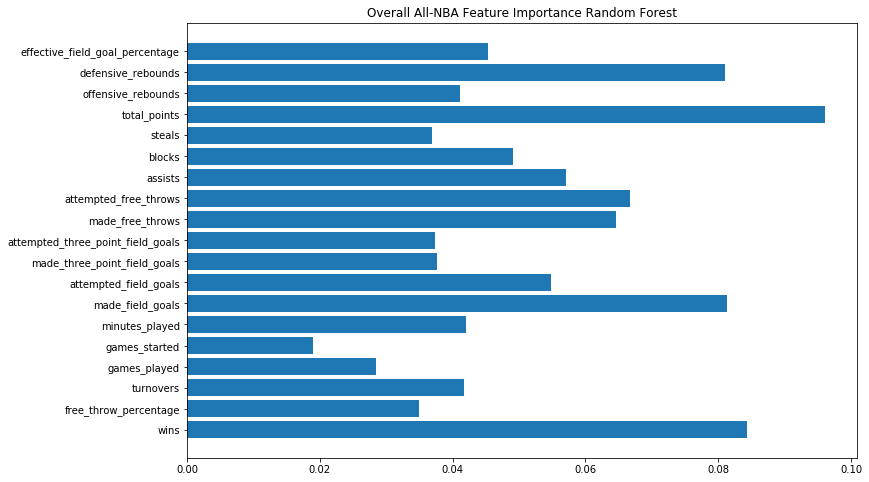

In [55]:
#feature importance
import matplotlib.pyplot as plt

importance = dict_models['Random Forest']['model'].feature_importances_
feature_names = ['wins','free_throw_percentage', 'turnovers', 'games_played', 'games_started', 'minutes_played', 'made_field_goals','attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'assists', 'blocks', 'steals', 'total_points', 'offensive_rebounds', 'defensive_rebounds', 'effective_field_goal_percentage']
print(feature_names)

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v), feature_names[i])


plt.figure(figsize=(12, 8))

plt.barh(feature_names, importance)
plt.title('Overall All-NBA Feature Importance Random Forest')
plt.show()



{0: 0.05886705827502755, 1: -0.0045796228048575974, 2: 0.07165392121252827, 3: 0.02595023577951461, 4: 0.032296361251490595, 5: 0.06542148086451519, 6: 0.15521885007517192, 7: 0.08335737961711663, 8: -0.012882032206872701, 9: -0.012853199977217917, 10: 0.14417698805015935, 11: 0.18121679938349963, 12: 0.028658486134710615, 13: 0.17007192009345445, 14: 0.03917982000050282, 15: 0.17875728408575484, 16: 0.11583368133382696, 17: 0.2682843846885276, 18: 0.03340393061152613}
[ 0.05886706 -0.00457962  0.07165392  0.02595024  0.03229636  0.06542148
  0.15521885  0.08335738 -0.01288203 -0.0128532   0.14417699  0.1812168
  0.02865849  0.17007192  0.03917982  0.17875728  0.11583368  0.26828438
  0.03340393]


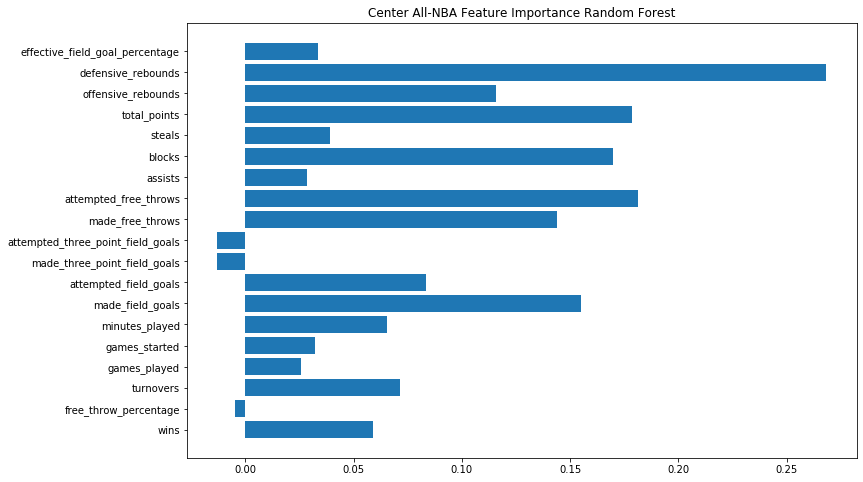

In [72]:
from sklearn.preprocessing import scale

def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)
    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(M), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out

result = class_feature_importance(X_train, Y_train, importance)

importance_c = np.zeros(len(feature_names))
res1 = result.get(1)
i = 0
while(i < len(feature_names)):
    for v in res1.values():
        importance_c[i] = v
        i+=1
        
plt.figure(figsize=(12, 8))
plt.barh(feature_names, importance_c)
plt.title('Center All-NBA Feature Importance Random Forest')
plt.show()


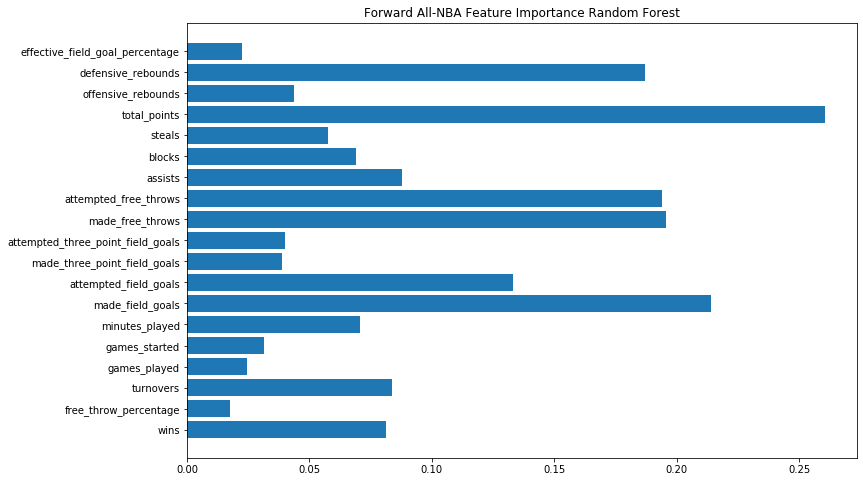

In [74]:
importance_f = np.zeros(len(feature_names))
res2 = result.get(2)
i = 0
while(i < len(feature_names)):
    for v in res2.values():
        importance_f[i] = v
        i+=1
        
plt.figure(figsize=(12, 8))
plt.barh(feature_names, importance_f)
plt.title('Forward All-NBA Feature Importance Random Forest')
plt.show()

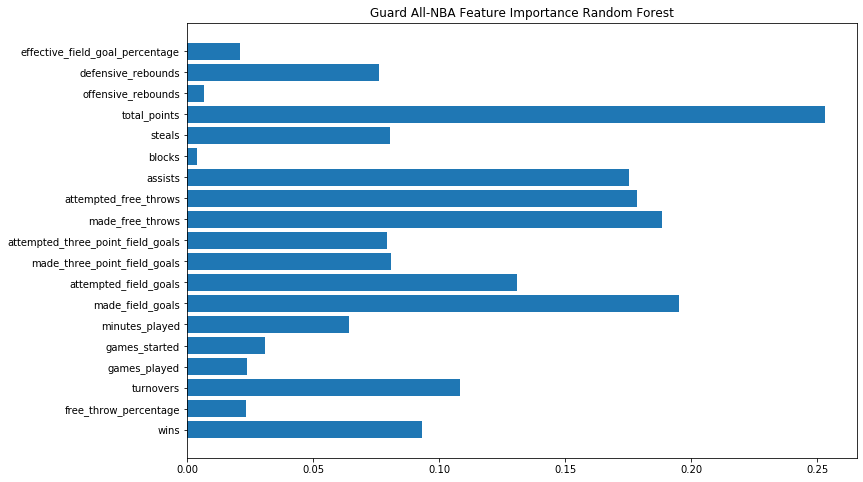

In [75]:
importance_g = np.zeros(len(feature_names))
res3 = result.get(3)
i = 0
while(i < len(feature_names)):
    for v in res3.values():
        importance_g[i] = v
        i+=1
        
plt.figure(figsize=(12, 8))
plt.barh(feature_names, importance_g)
plt.title('Guard All-NBA Feature Importance Random Forest')
plt.show()